Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [ ]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [ ]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Kindle_store
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [40]:
# importa dataset 'amazon kindle store'
data = pd.read_csv("../datasets/Kindle_Store.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Kindle_Store'
user_col = 'user_id'

In [41]:
data.shape

(5722988, 4)

In [42]:
data.head()

,user_id,item_id,rating,timestamp
0,1423600150,A27UD5HYAKBL97,4.0,1356739200
1,1423600150,A8P5DK8LLOYGH,5.0,1330992000
2,1423600150,A3OM9W7DXSUIIY,5.0,1250035200
3,1423600150,A3DPAR2PWB9BT8,3.0,1162512000
4,1423600150,A2ONTBSAX7GIOV,5.0,1144713600


In [43]:
data['user_id'].value_counts() >= 5

B00C2WDD5I     True
B00YN6XHMU     True
B00DMCV7K0     True
B0142IHZPI     True
B00XSSYR50     True
              ...  
B004E9U81O    False
B01EUO5SIA    False
B018IDWS64    False
B00DXXGFFK    False
B003SE6Z04    False
Name: user_id, Length: 493849, dtype: bool

In [44]:
k_core_users = data['user_id'].value_counts()[ data['user_id'].value_counts() >= 5 ].index

In [45]:
data = data.set_index('user_id').loc[k_core_users].reset_index()

In [46]:
data.shape

(5138479, 4)

### Keep only high ratings

<Axes: ylabel='Frequency'>

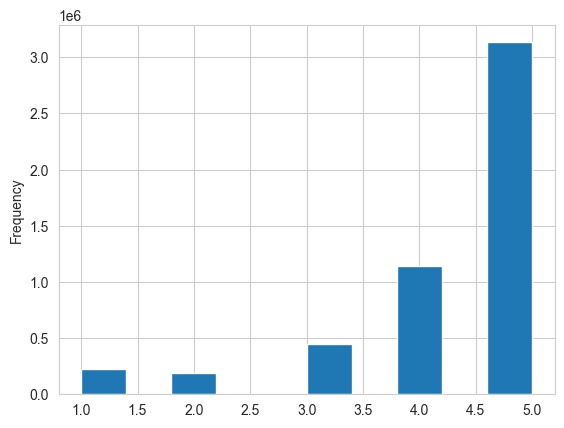

In [47]:
data['rating'].plot(kind='hist')

In [48]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [49]:
pos_ratings

5.0

In [50]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [51]:
# number of remaining cases
data.shape[0]

3133324

### Convert timestamp

In [52]:
%%time
# data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
# data = data.sort_values(by='date') # sort by date


data['date'] = data['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: total: 1.25 s
Wall time: 5.01 s


In [53]:
data.head()

,user_id,item_id,timestamp,date
108347,B01D6NM4VA,A3IMAGCSRXL12Y,872208000,1997-08-22
2988516,B0046A9VX2,A2KTTIY7HSLBFV,872208000,1997-08-22
3877537,B003R4ZOP2,A20UN1U2RQ0Y36,872640000,1997-08-27
624889,B01CKOE0VS,A2MWX5AW7CF0S6,872985600,1997-08-31
2111594,B003ZUXXCO,A3HK0X2QGA7O1V,873158400,1997-09-02


In [54]:
data.tail()

,user_id,item_id,timestamp,date
2102239,B01GIM0CMY,A1VINNUKFWTBP5,1538352000,2018-10-01
3413792,B01GDD5XMW,A3R6DJPLQALR0G,1538352000,2018-10-01
4115845,B01GBSN7HC,A1OMUMW86KOHCZ,1538352000,2018-10-01
4983855,B01HAKH654,A2XP39MF3QAZV0,1538438400,2018-10-02
2809732,B01H45TR0M,A2N5017ICZCW2L,1538438400,2018-10-02


In [55]:
%%time
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: total: 24.5 s
Wall time: 1min 16s


## Evaluating Time defined Buckets 

Sampling the dataset

In [56]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: total: 297 ms
Wall time: 1.37 s


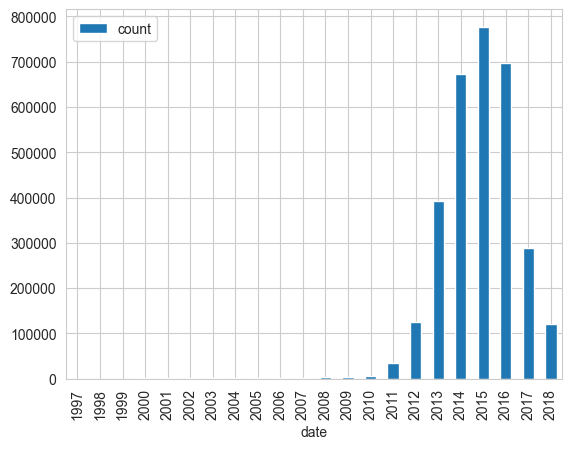

In [58]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar');

In [59]:
# y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
y_filter = (data['date'] < datetime.strptime('2014-03', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 

In [60]:
data = data[y_filter]

In [61]:
# number of remaining cases
data.shape[0]

98610

In [62]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((98610, 4), 27803, 72977)

Sampling the dataset - only most frequent users (overall)

In [63]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique() # day and year are the same, so automatically counts per month

CPU times: total: 31.2 ms
Wall time: 96.3 ms


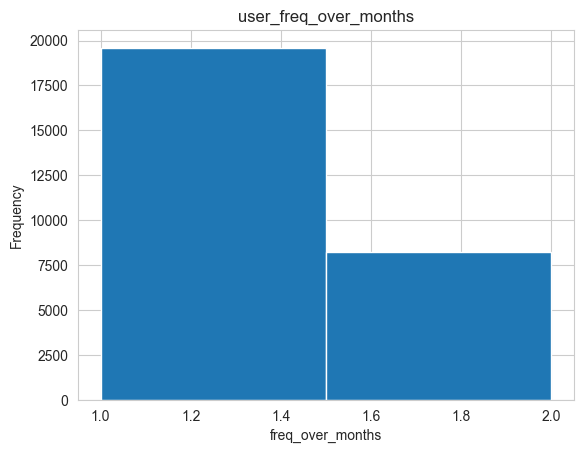

In [83]:
user_freq_over_months.plot(kind='hist',
                            bins=user_freq_over_months.max(),
                            title='user_freq_over_months').set_xlabel('freq_over_months');#.set_ylabel('count')

In [84]:
# # sample the dataset to contain only interactions from frequent users (that occur every month).
# # there is still a huge number of interactions - 1694351
# _ = data.set_index('user_id').loc[freq_users]
# _.shape
_ = data.set_index('user_id').copy()

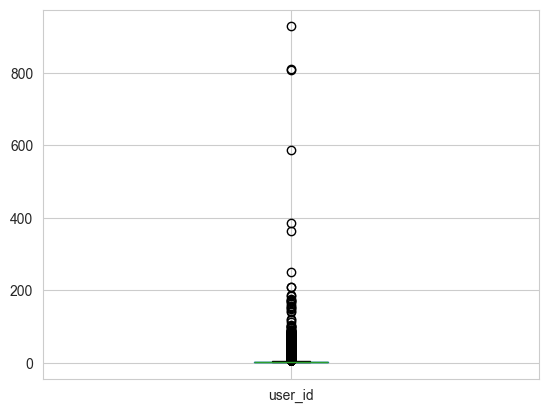

In [85]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box');

In [86]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [87]:
# to user, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [88]:
prop = 0.5
s = round( len( u )*prop )

In [89]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [90]:
_.loc[sampled_users]

,item_id,timestamp,date
user_id,,,
B00HZUGLAQ,A12JOX2KYT309D,1390435200,2014-01-01
B00HZUGLAQ,A1Y5T4OISWL1Q6,1390435200,2014-01-01
B00HZUGLAQ,A20NAYUCXCPO1C,1391040000,2014-01-01
B00HZUGLAQ,A15CSPSLMOCAOU,1391472000,2014-02-01
B00HZUGLAQ,A34KD80BAXVOZ3,1392336000,2014-02-01
...,...,...,...
B00EZ5N6Z2,A2SOO1UXHDTBQY,1393286400,2014-02-01
B00CPURR22,A1Z6PKT30DP4CL,1388707200,2014-01-01
B00CPURR22,A3QW65RBPV8Z3R,1389484800,2014-01-01


<Axes: >

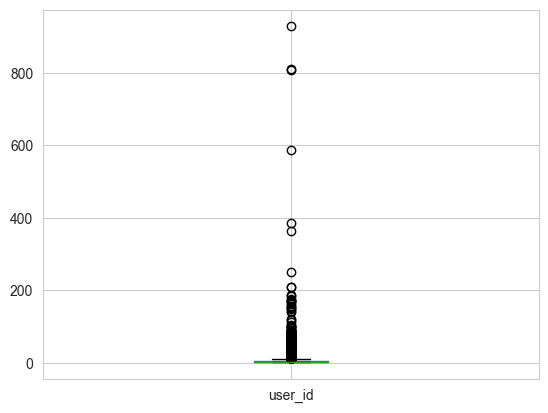

In [91]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box')

CPU times: total: 172 ms
Wall time: 541 ms


<Axes: ylabel='Frequency'>

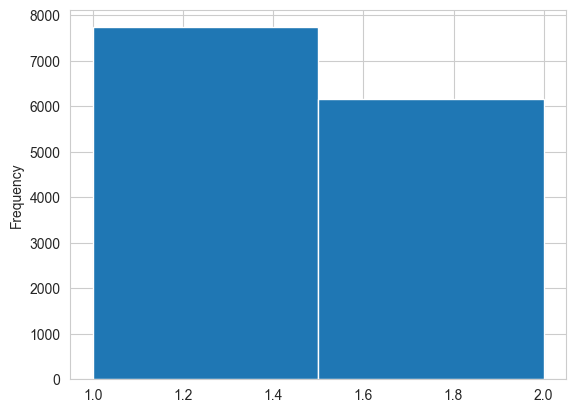

In [92]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max())

In [93]:
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(27803, 72977)

In [94]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()['user_id'].nunique(), _.loc[sampled_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(13902, 59241)

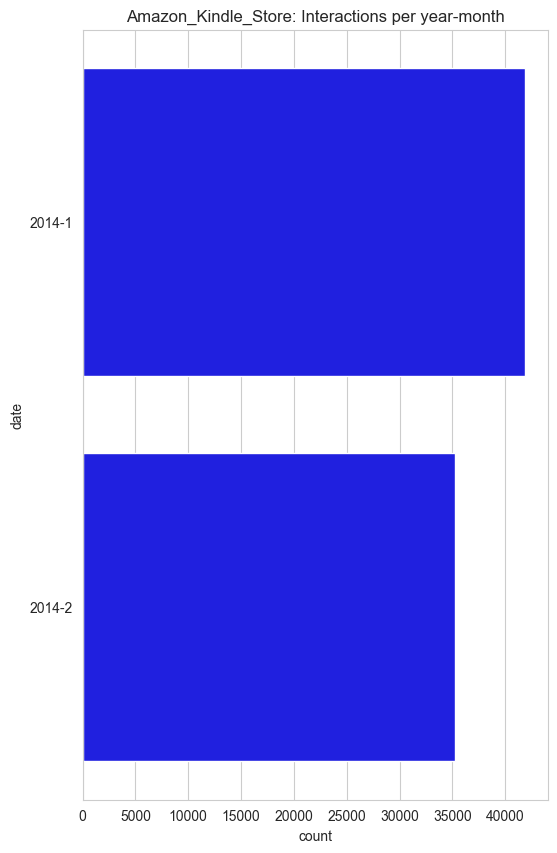

In [95]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [97]:
USE_THRESHOLD = True
# all users 0.009303
# USING p = 0.75 increased performance, by a bit, 0.011201
# USING p = 0.5 increased performance, by a bit, 0.010228
# USING p = 0.25 increased performance, 0.010836

if USE_THRESHOLD: 
    data = _.loc[sampled_users].reset_index()
    data = data.sort_values(by=['timestamp', 'user_id', 'item_id'])
    print(data.shape[0])
else:
    print(data.shape[0])
# new sample
data.to_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv', index=False)

77145


How many interactions occur in each month / year?

In [98]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: total: 0 ns
Wall time: 395 ms


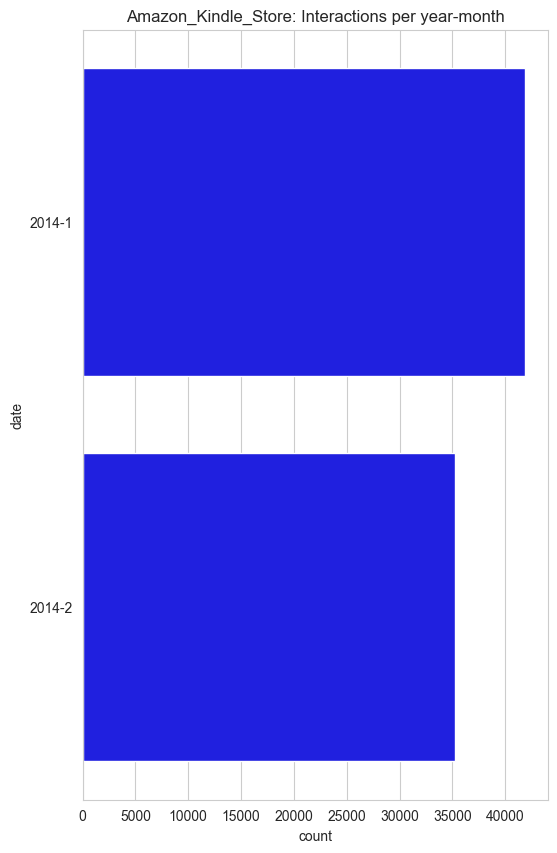

In [99]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [100]:
%%time
# 3min 16s
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv', index=False)

0.0 %
50.0 %
CPU times: total: 41.5 s
Wall time: 4min 3s


In [101]:
user_presence_df.head()

,UserID,month_%
0,B00EPSIIAW,1.0
1,B00GJ3P9OO,1.0
2,B00GI2D682,1.0
3,B00GI293M0,1.0
4,B00GI28W5E,1.0


AttributeError: 'Axes' object has no attribute 'is_first_col'

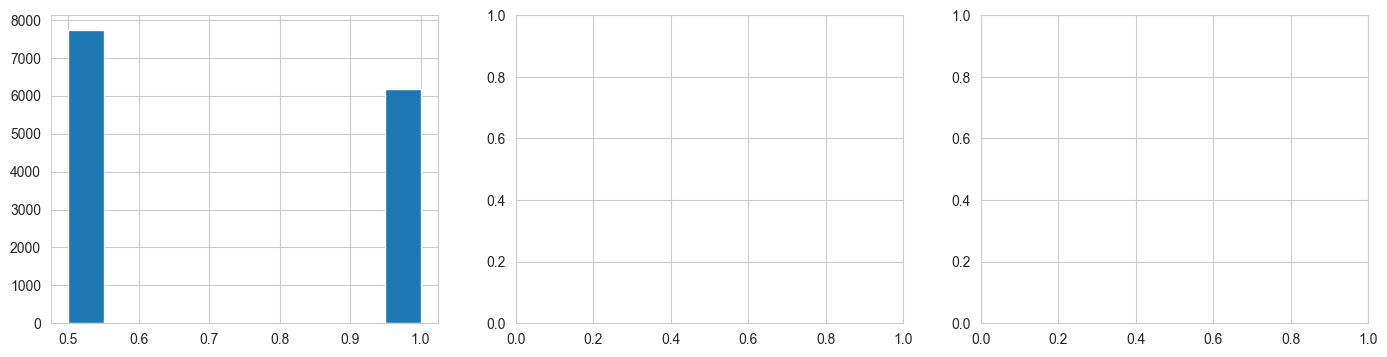

In [102]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [103]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [104]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [105]:
# defining threshold
frequency_threshold = 1

In [106]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

6167 users of 13902 (44.361%) occurr in 100% or more months.


In [107]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

['output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib']